# Rag From Scratch: Overview

These notebooks walk through the process of building RAG app(s) from scratch.

They will build towards a broader understanding of the RAG langscape, as shown here:

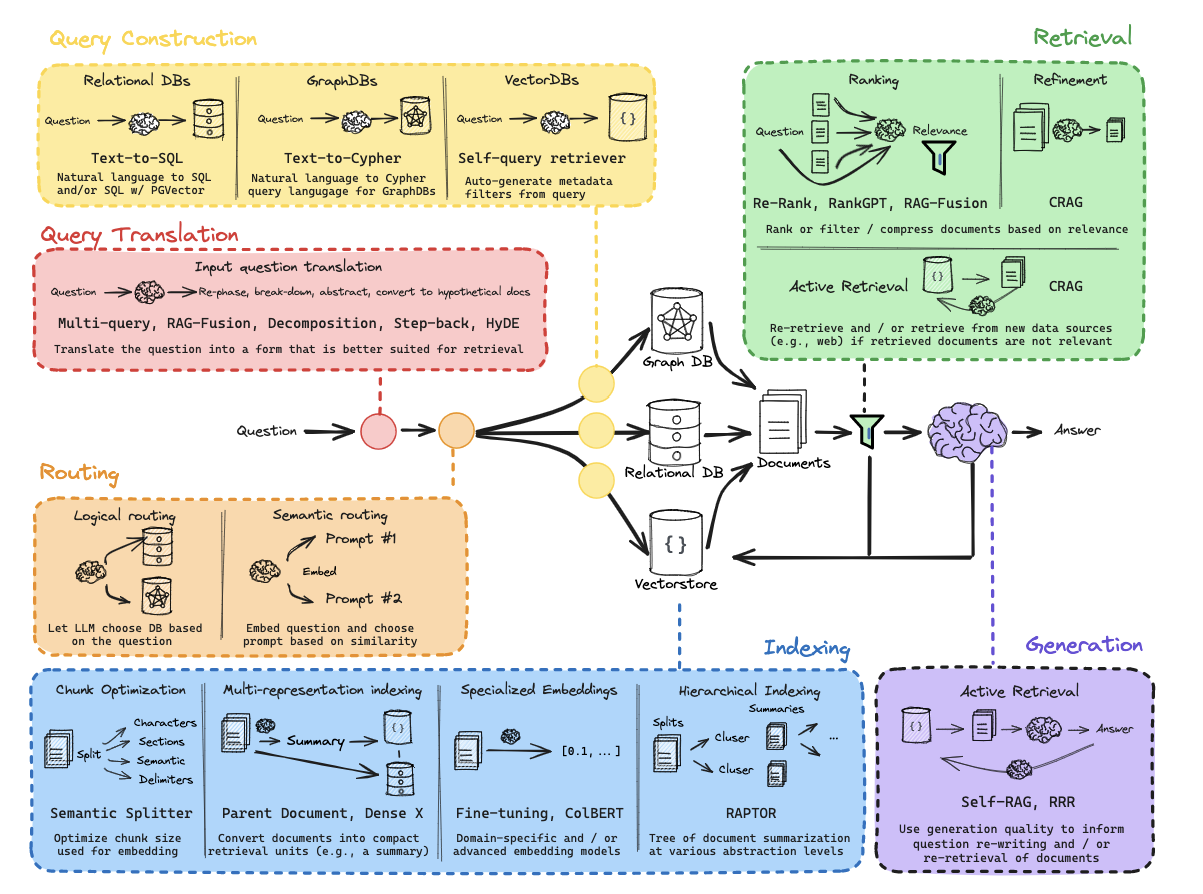

## Enviornment

`(1) Packages`

In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

`(2) LangSmith`

https://docs.smith.langchain.com/

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

`(3) API Keys`

In [ ]:
os.environ['OPENAI_API_KEY'] = <your-api-key>

## Part 1: Overview
 
[RAG quickstart](https://python.langchain.com/docs/use_cases/question_answering/quickstart)

In [ ]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

#### INDEXING ####

# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
rag_chain.invoke("What is Task Decomposition?")

## Part 2: Indexing

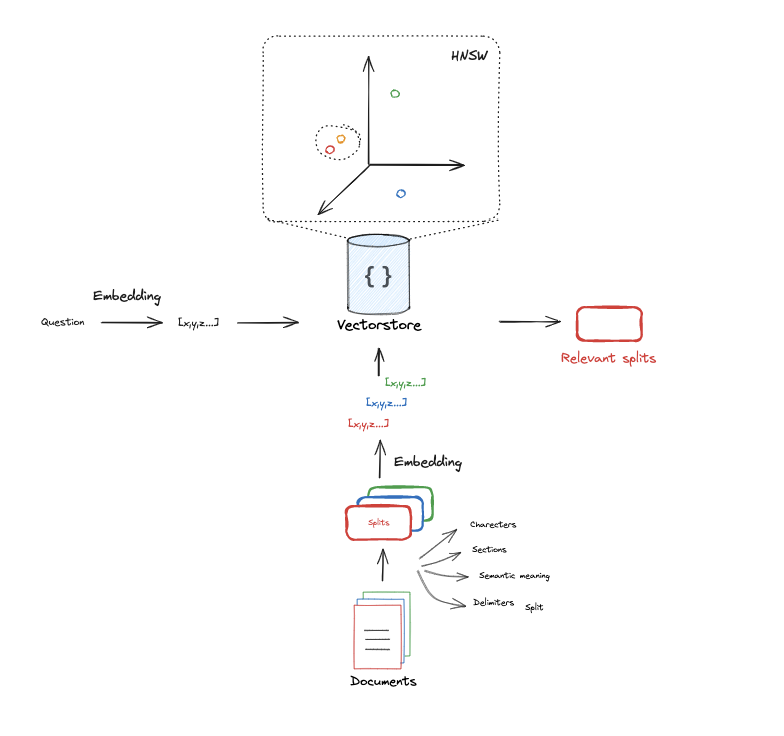

In [ ]:
# Documents
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

[Count tokens](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb) considering [~4 char / token](https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them)

In [ ]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string(question, "cl100k_base")

[Text embedding models](https://python.langchain.com/docs/integrations/text_embedding/openai)

In [ ]:
from langchain_openai import OpenAIEmbeddings
embd = OpenAIEmbeddings()
query_result = embd.embed_query(question)
document_result = embd.embed_query(document)
len(query_result)

[Cosine similarity](https://platform.openai.com/docs/guides/embeddings/frequently-asked-questions) is reccomended (1 indicates identical) for OpenAI embeddings.

In [ ]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

[Document Loaders](https://python.langchain.com/docs/integrations/document_loaders/)

In [ ]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

[Splitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter)

> This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.

In [ ]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

[Vectorstores](https://python.langchain.com/docs/integrations/vectorstores/)

In [ ]:
# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

## Part 3: Retrieval

In [ ]:
# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=OpenAIEmbeddings())


retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [ ]:
docs = retriever.get_relevant_documents("What is Task Decomposition?")

In [ ]:
len(docs)

## Part 4: Generation

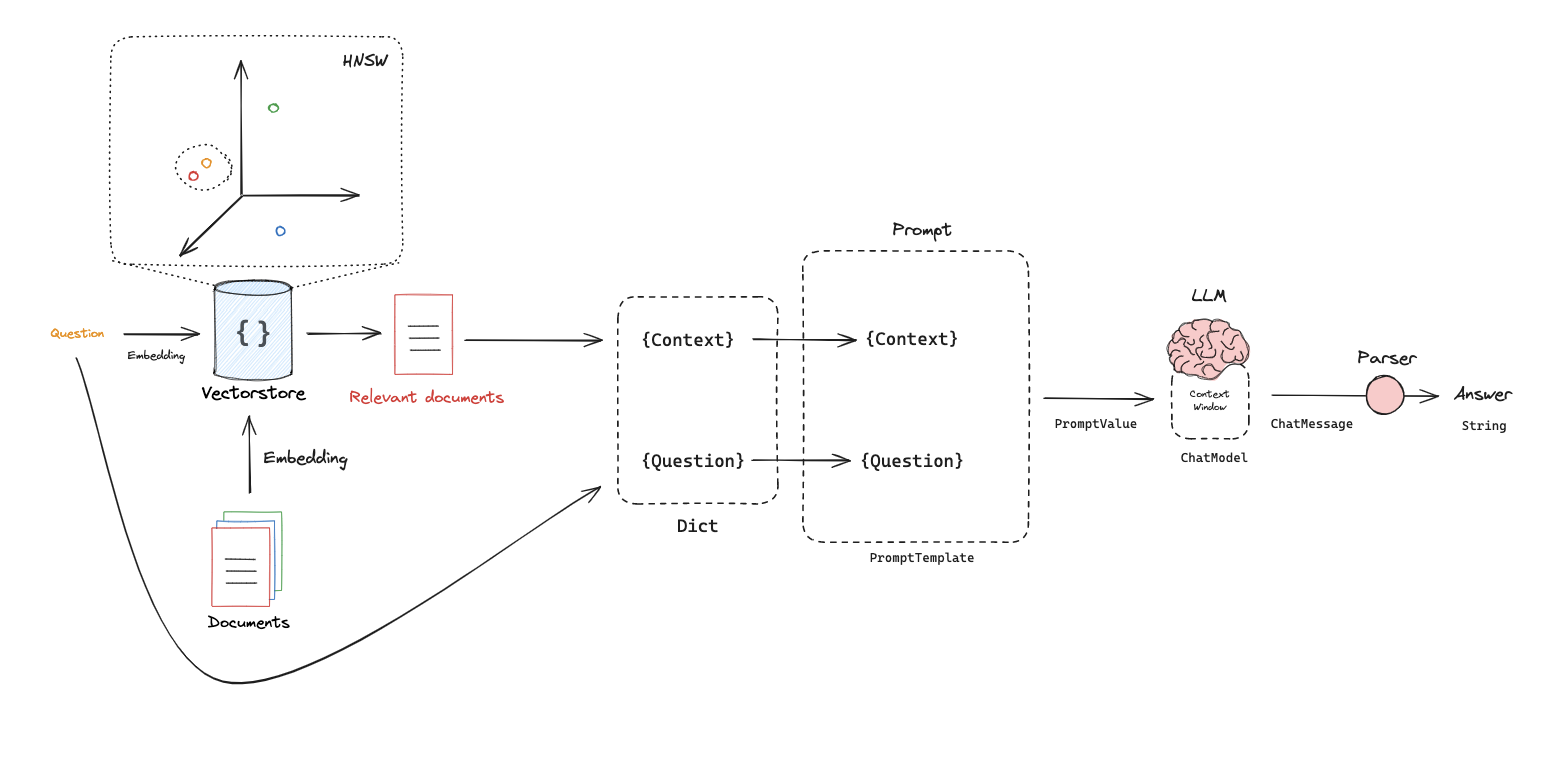

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

In [ ]:
# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [ ]:
# Chain
chain = prompt | llm

In [ ]:
# Run
chain.invoke({"context":docs,"question":"What is Task Decomposition?"})

In [ ]:
from langchain import hub
prompt_hub_rag = hub.pull("rlm/rag-prompt")

In [ ]:
prompt_hub_rag

[RAG chains](https://python.langchain.com/docs/expression_language/get_started#rag-search-example)

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")